In [1]:
# Chargement des librairies nécessaires
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)
library(repr)
library(caret)

# fix random seed for reproducibility
set.seed(1234)

## GRAPH SETTINGS ##
# Save original parameters (optional)
original_par <- par(no.readonly = TRUE)

# Set global scaling factors (1.5x default size)
par(
  cex.lab = 1.5,   # Axis labels
  cex.axis = 1.5,  # Axis text (tick labels)
  cex.main = 1.5,  # Main title
  cex.sub = 1.5    # Subtitle
)

# Define a custom theme with larger fonts
custom_theme <- theme(
  text = element_text(size = 16),            # Global text size
  axis.title = element_text(size = 18),      # Axis labels
  axis.text = element_text(size = 14),       # Axis tick labels
  plot.title = element_text(size = 20),      # Main title
  plot.subtitle = element_text(size = 16)    # Subtitle
)

# Apply the theme to all future plots
theme_set(custom_theme)


## DATA LOADING & PROCESSING ##
# Load data
path <- "../../" # modifier le nombre de ../ si nécessaire
gym <- read.table(paste(path, "gym_members_exercise_tracking.csv", sep = ""),
                    sep = ",", header = TRUE)

gym[,'Gender'] <- as.factor(gym[,'Gender'])
gym[,'Workout_Type'] <- as.factor(gym[,'Workout_Type'])
gym[,'Experience_Level'] <- as.factor(gym[,'Experience_Level'])
gym[,'Workout_Frequency..days.week.'] <- as.factor(gym[,'Workout_Frequency..days.week.'])

gym[, "Weight..kg."] <- log(gym[,"Weight..kg."])

max_fat <- max(gym[,"Fat_Percentage"])
gym[, "Fat_Percentage"] <- sqrt((max_fat + 1) - gym[,"Fat_Percentage"])

# renome les variables Weight..kg. et BMI en LWeight et LBMI
names(gym)[names(gym) == "Weight..kg."] <- "LWeight"
names(gym)[names(gym) == "Fat_Percentage"] <- "SFat_Percentage"

gym <- gym %>% select(-c(BMI))

# divide data into training and testing sets for experience level
trainIndex <- createDataPartition(gym$Experience_Level, p = .8, 
                                  list = FALSE, 
                                  times = 1)
gym_train <- gym[ trainIndex,]
gym_test  <- gym[-trainIndex,]

# Normalize the data
gym_train_scaled = gym_train
scaler <- scale(gym_train[,-c(2,10,13,14)])

# Extract the center and scale attributes
center <- attr(scaler, "scaled:center")
scale <- attr(scaler, "scaled:scale")

gym_train_scaled[,-c(2,10,13,14)] <- scale(gym_train[,-c(2,10,13,14)], center = center, scale = scale)

gym_test_scaled = gym_test
gym_test_scaled[,-c(2,10,13,14)] <- scale(gym_test[,-c(2,10,13,14)], center = center, scale = scale)


cat("Data loaded and preprocessed")


## FUNCTION DEFINITIONS ##

# Function to plot residuals
# x: predicted values
# y: residuals
gplot.res <- function(x, y, titre = "titre"){
    ggplot(data.frame(x=x, y=y),aes(x,y))+
    geom_point(col = "blue")+#xlim(0, 250)+ylim(-155, 155)+
    ylab("Résidus")+ xlab("Valeurs prédites")+
    ggtitle(titre)+
    geom_hline(yintercept = 0,col="green")
}

# Function to plot ROC curve
# model: model to evaluate
# data: data to evaluate
# title: title of the plot
plot_roc <- function(model, data, title = "ROC curve"){
    pred <- predict(model, data, type = "response")
    roc <- roc(data$Experience_Level, pred)
    auc <- round(auc(roc), 2)
    plot(roc, main = title)
    text(0.8, 0.2, paste("AUC = ", auc), cex = 1.5)
}

# Function that compute R2

# compute_R2 <- function(model, newdata = NA){
#   if newdata == NA{
#     residuals <- predict(model)
#       rss <- sum()
#       tss <- 
# }
#   res.tree.cal.cp_high.test <- predict(tree.reg.cal.cp_high, newdata = gym_test)
#   mse_test_cal_cp_high <- mean((res.tree.cal.cp_high.test - gym_train[,"Calories_Burned"])^2)
#   rss_cal_cp_high <- sum((res.tree.cal.cp_high.test - gym_test[,"Calories_Burned"])^2)
#   tss_cal_cp_high <- sum((gym_test[,"Calories_Burned"] - mean(gym_test[,"Calories_Burned"]))^2)
#   r2_test_cal_cp_high <- 1 - rss_cal_cp_high / tss_cal_cp_high
# }



Warning message:
"le package 'lubridate' a 'et'e compil'e avec la version R 4.4.1"
-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v lubridate 1.9.4     v tibble    3.2.1
v purrr     1.0.2     v tidyr     1.3.1
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attachement du package : 'gridExtra'


L'objet suivant est masqu'e depuis 'package:dplyr':

    combine


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attachement du package : 'plotly'


L'objet suivant est masqu'e depuis 'package:ggplot2':

    last_plot


L'objet suivant est masqu'e depuis 'package:stats':

    filter


L'objet suivant est masqu'e depuis 'package:graphics':

Data loaded and preprocessed

In [2]:
summary(gym_train_scaled)
summary(gym_test_scaled)

      Age              Gender       LWeight           Height..m.      
 Min.   :-1.70033   Female:384   Min.   :-2.06411   Min.   :-1.74278  
 1st Qu.:-0.88351   Male  :395   1st Qu.:-0.70877   1st Qu.:-0.79206  
 Median : 0.09668                Median :-0.05133   Median :-0.07902  
 Mean   : 0.00000                Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.91350                3rd Qu.: 0.67508   3rd Qu.: 0.55479  
 Max.   : 1.64864                Max.   : 2.18326   Max.   : 2.21854  
    Max_BPM            Avg_BPM          Resting_BPM      
 Min.   :-1.70393   Min.   :-1.66558   Min.   :-1.66962  
 1st Qu.:-0.84195   1st Qu.:-0.90414   1st Qu.:-0.84618  
 Median : 0.02003   Median :-0.07349   Median :-0.02273  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.88201   3rd Qu.: 0.89561   3rd Qu.: 0.80072  
 Max.   : 1.65779   Max.   : 1.72627   Max.   : 1.62417  
 Session_Duration..hours. Calories_Burned     Workout_Type SFat_Percentage   
 Min.   :-2.20445  

      Age              Gender       LWeight           Height..m.      
 Min.   :-1.70033   Female: 78   Min.   :-2.06411   Min.   :-1.74278  
 1st Qu.:-0.88351   Male  :116   1st Qu.:-0.74142   1st Qu.:-0.71283  
 Median :-0.06669                Median :-0.01540   Median :-0.07902  
 Mean   :-0.05448                Mean   : 0.03039   Mean   : 0.10352  
 3rd Qu.: 0.66845                3rd Qu.: 0.77183   3rd Qu.: 0.95092  
 Max.   : 1.64864                Max.   : 2.14138   Max.   : 2.21854  
    Max_BPM            Avg_BPM         Resting_BPM      
 Min.   :-1.70393   Min.   :-1.6656   Min.   :-1.66962  
 1st Qu.:-0.66956   1st Qu.:-0.9041   1st Qu.:-0.84618  
 Median : 0.10623   Median :-0.1427   Median : 0.11451  
 Mean   : 0.05024   Mean   :-0.1024   Mean   : 0.03953  
 3rd Qu.: 0.88201   3rd Qu.: 0.7399   3rd Qu.: 0.93796  
 Max.   : 1.65779   Max.   : 1.6571   Max.   : 1.62417  
 Session_Duration..hours. Calories_Burned      Workout_Type SFat_Percentage   
 Min.   :-2.17545        

## CART & Agregation
### Classification Trees

- Fit a classification tree.
- Prune the tree using cross-validation.
- Plot: Decision tree structure.


Attachement du package : 'MLmetrics'


Les objets suivants sont masqu'es depuis 'package:caret':

    MAE, RMSE


L'objet suivant est masqu'e depuis 'package:base':

    Recall




Test Set Performance:
- Accuracy: 0.8711 
- Log loss: 0.2528 (lower is better)
- Confusion Matrix:
          Reference
Prediction  1  2  3
         1 64 14  0
         2 11 67  0
         3  0  0 38

Training Set Performance:
- Accuracy: 0.9474 
- Log loss: 0.1257 (lower is better)
- Confusion Matrix:
          Reference
Prediction   1   2   3
         1 276  16   0
         2  25 309   0
         3   0   0 153
Nombre de noeuds dans l'arbre :  37 
Nombre de feuilles dans l'arbre :  19 


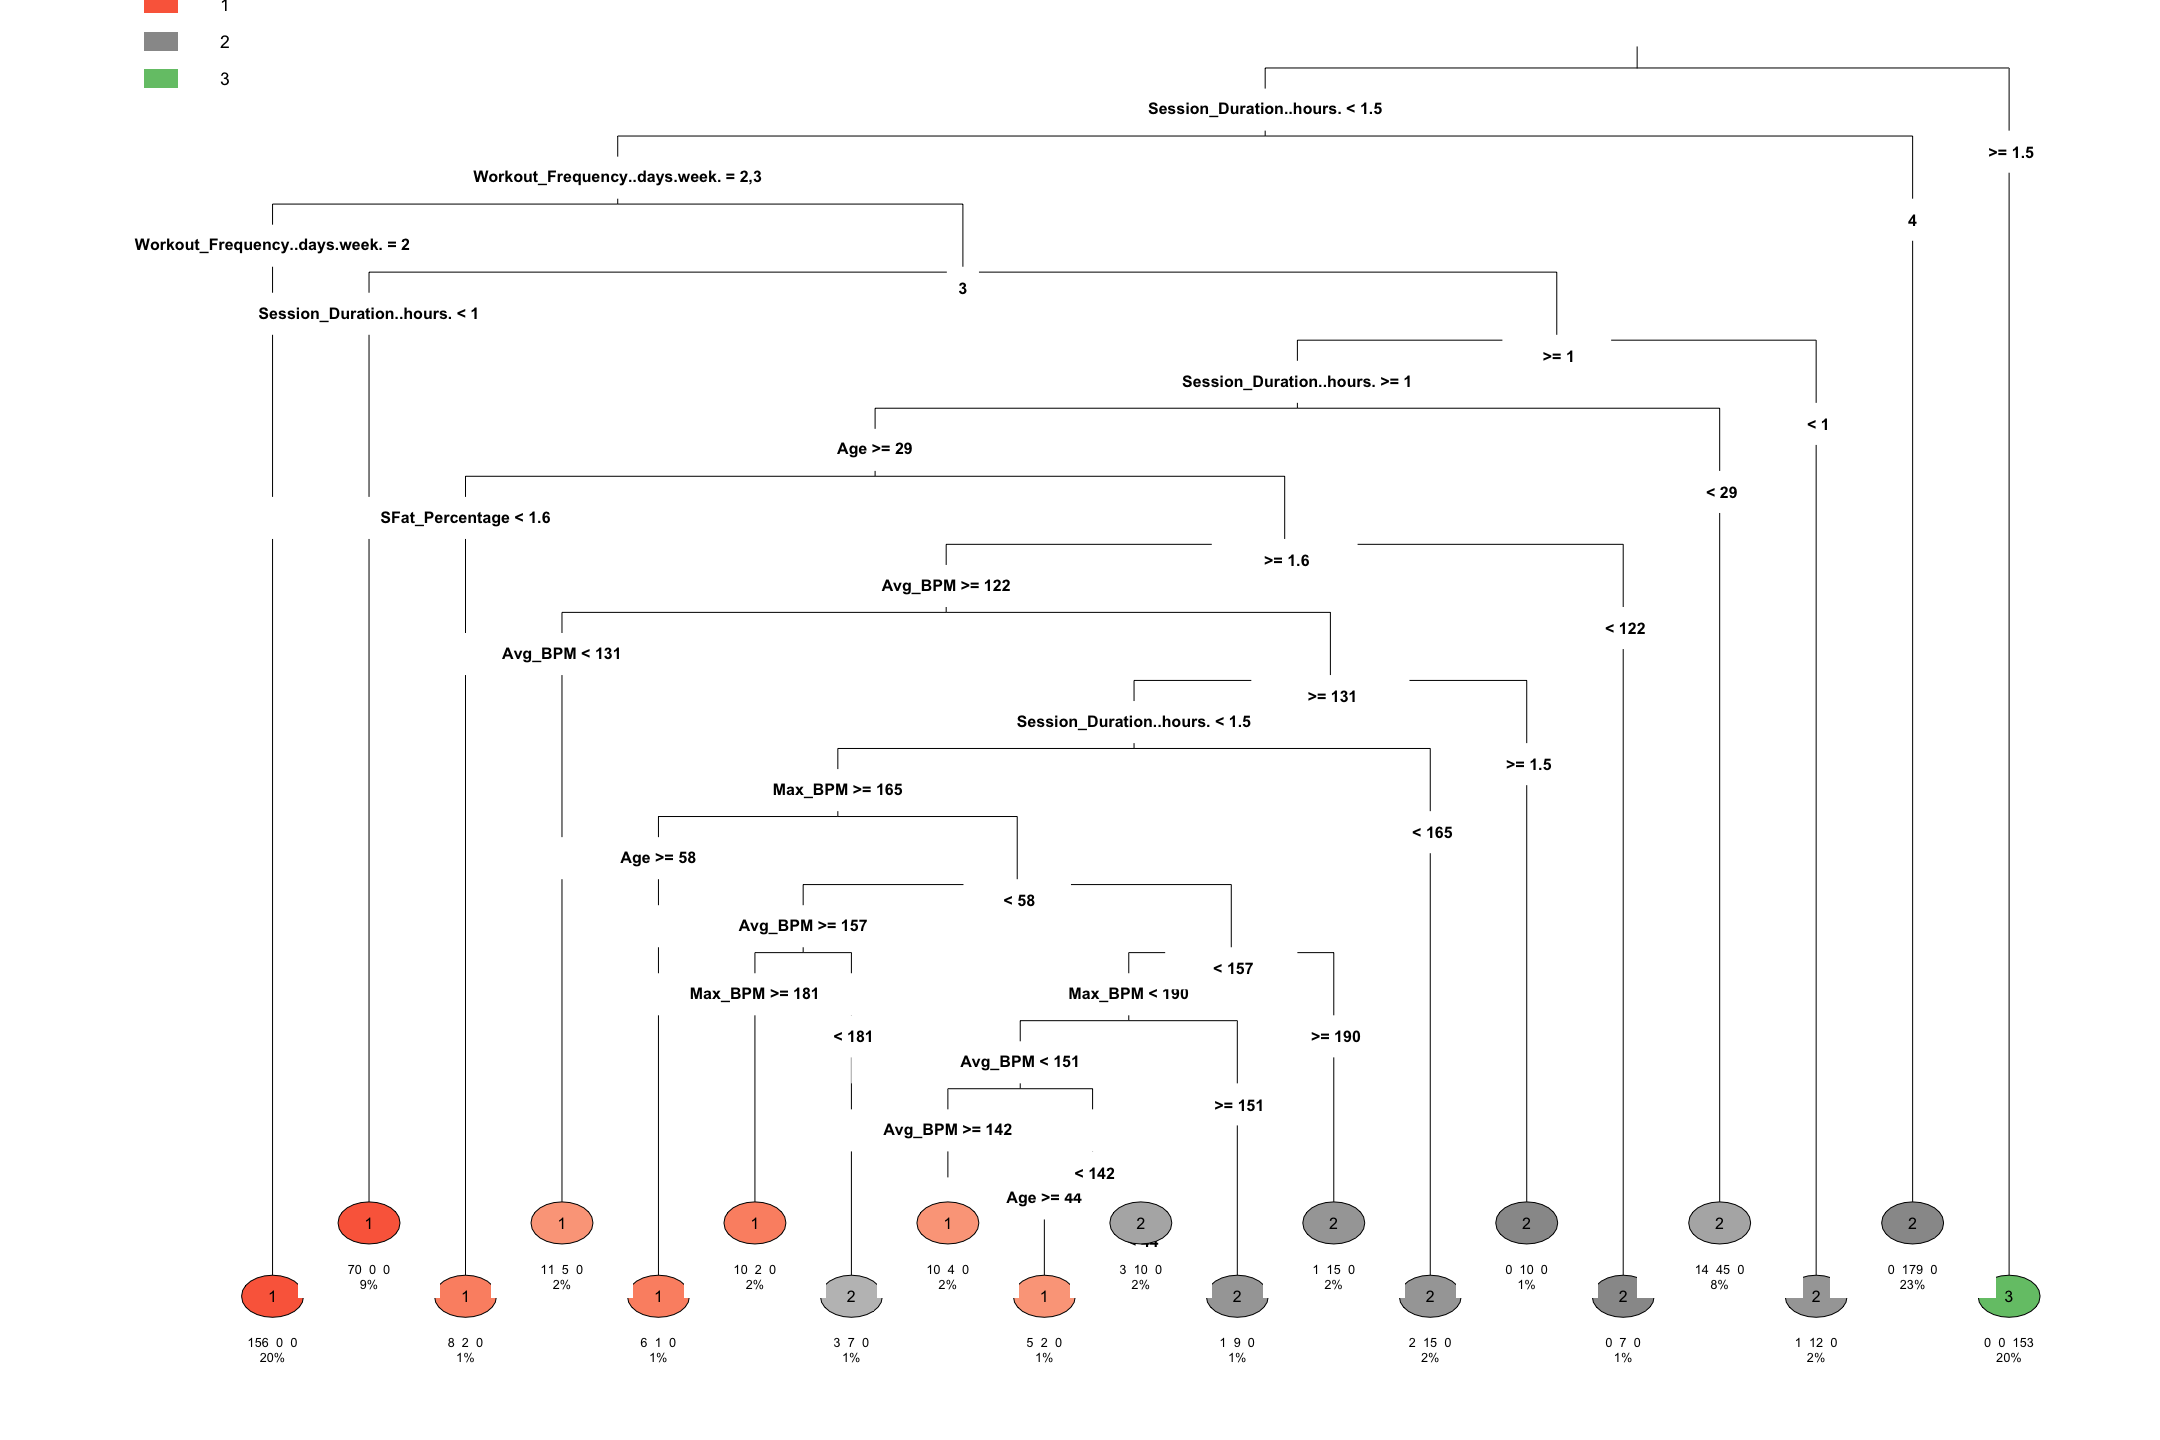

In [3]:
# Fit a regression tree model
library(rpart)
library(rpart.plot)
library(MLmetrics)

# Fit a regression tree model for Experience_Level using the training set
tree.reg.exp <- rpart(Experience_Level ~ ., data = gym_train, control=rpart.control(cp=0.0001))

options(repr.plot.width=18, repr.plot.height=12)
# Plot the tree
rpart.plot(tree.reg.exp, extra = 101, type = 3, under = TRUE, cex = 0.8, tweak = 1)

# Convert the target to binary for ROC analysis
# Here we're treating Experience_Level as a binary classification problem
# First, get predicted probabilities for each class
pred_exp_tree_test <- predict(tree.reg.exp, gym_test, type = "prob")
pred_exp_tree_train <- predict(tree.reg.exp, gym_train, type = "prob")

# Get actual classes and convert to numeric matrix for MultiLogLoss
actual_classes <- gym_test$Experience_Level
actual_matrix <- model.matrix(~actual_classes-1)

# Calculate log loss using MultiLogLoss from MLmetrics
logloss_value <- MultiLogLoss(y_pred = pred_exp_tree_test, y_true = actual_matrix)

# Calculate confusion matrix for test set
pred_classes_test <- predict(tree.reg.exp, gym_test, type="class")
conf_matrix_test <- confusionMatrix(pred_classes_test, gym_test$Experience_Level)

cat("Test Set Performance:\n")
cat("- Accuracy:", round(conf_matrix_test$overall["Accuracy"], 4), "\n")
cat("- Log loss:", round(logloss_value, 4), "(lower is better)\n")
cat("- Confusion Matrix:\n")
print(conf_matrix_test$table)
cat("\n")

# Compute the metrics for the gym_train set
# Calculate confusion matrix for training set
pred_classes_train <- predict(tree.reg.exp, gym_train, type="class")
conf_matrix_train <- confusionMatrix(pred_classes_train, gym_train$Experience_Level)

# Get actual classes and convert to numeric matrix for MultiLogLoss
actual_classes_train <- gym_train$Experience_Level
actual_matrix_train <- model.matrix(~actual_classes_train-1)

# Calculate log loss using MultiLogLoss from MLmetrics
logloss_value_train <- MultiLogLoss(y_pred = pred_exp_tree_train, y_true = actual_matrix_train)

cat("Training Set Performance:\n")
cat("- Accuracy:", round(conf_matrix_train$overall["Accuracy"], 4), "\n")
cat("- Log loss:", round(logloss_value_train, 4), "(lower is better)\n")
cat("- Confusion Matrix:\n")
print(conf_matrix_train$table)

# Afficher le nombre de noeuds et de feuilles en français
cat("Nombre de noeuds dans l'arbre : ", length(tree.reg.exp$frame$var), "\n")
cat("Nombre de feuilles dans l'arbre : ", length(tree.reg.exp$frame$var[tree.reg.exp$frame$var == "<leaf>"]), "\n")

**Interprétation :**

L'arbre de régression construit avec un paramètre de complexité faible (`cp = 0.0001`) montre des performances solides mais indique un potentiel sur-apprentissage.

**Performance sur le jeu de test :**
- **Précision :** 87,11 % - Bonne capacité à classer correctement les observations.
- **Log loss :** 0.2528 - Indique des prédictions probabilistes bien calibrées.
- **Matrice de confusion :** Bonne distinction des classes, mais quelques confusions entre les classes 1 et 2.

**Performance sur le jeu d'entraînement :**
- **Précision :** 94,74 % - Ajustement presque parfait aux données d'entraînement.
- **Log loss :** 0.1257 - Confirme un ajustement très précis.

**Conclusion :**
L'écart entre les performances d'entraînement et de test (94,74 % vs 87,11 %) et les log loss (0.1257 vs 0.2528) suggère un sur-apprentissage dû à une complexité excessive. Malgré cela, le modèle capture bien les relations dans les données. Une optimisation du paramètre de complexité (`cp`) pourrait améliorer la généralisation.

### **Sélection du paramètre de complexité (cp) par validation croisée**

Pour éviter le sur-apprentissage et obtenir un arbre de régression optimal, il est important de choisir correctement le paramètre de complexité (`cp`). La méthode classique consiste à utiliser la validation croisée intégrée à l’algorithme `rpart` :

- On ajuste d’abord un arbre avec une valeur de `cp` très faible, ce qui permet à l’arbre de se développer au maximum.
- `rpart` réalise automatiquement une validation croisée (par défaut à 10 plis) et enregistre, pour différentes valeurs de `cp`, l’erreur de validation croisée associée.
- On visualise ensuite l’évolution de l’erreur de validation croisée en fonction de `cp` à l’aide de la fonction `plotcp()`.
- Le `cp` optimal est celui qui minimise l’erreur de validation croisée (`xerror`). On peut aussi appliquer la règle du 1-SE pour sélectionner un arbre plus simple si plusieurs valeurs de `cp` donnent des erreurs similaires.
- Enfin, on élague l’arbre initial avec la valeur optimale de `cp` pour obtenir un modèle plus parcimonieux et mieux généralisant.

Cette démarche permet de sélectionner automatiquement la complexité de l’arbre en fonction des performances sur des données non vues.

Le cp optimal est : 0.004405286 


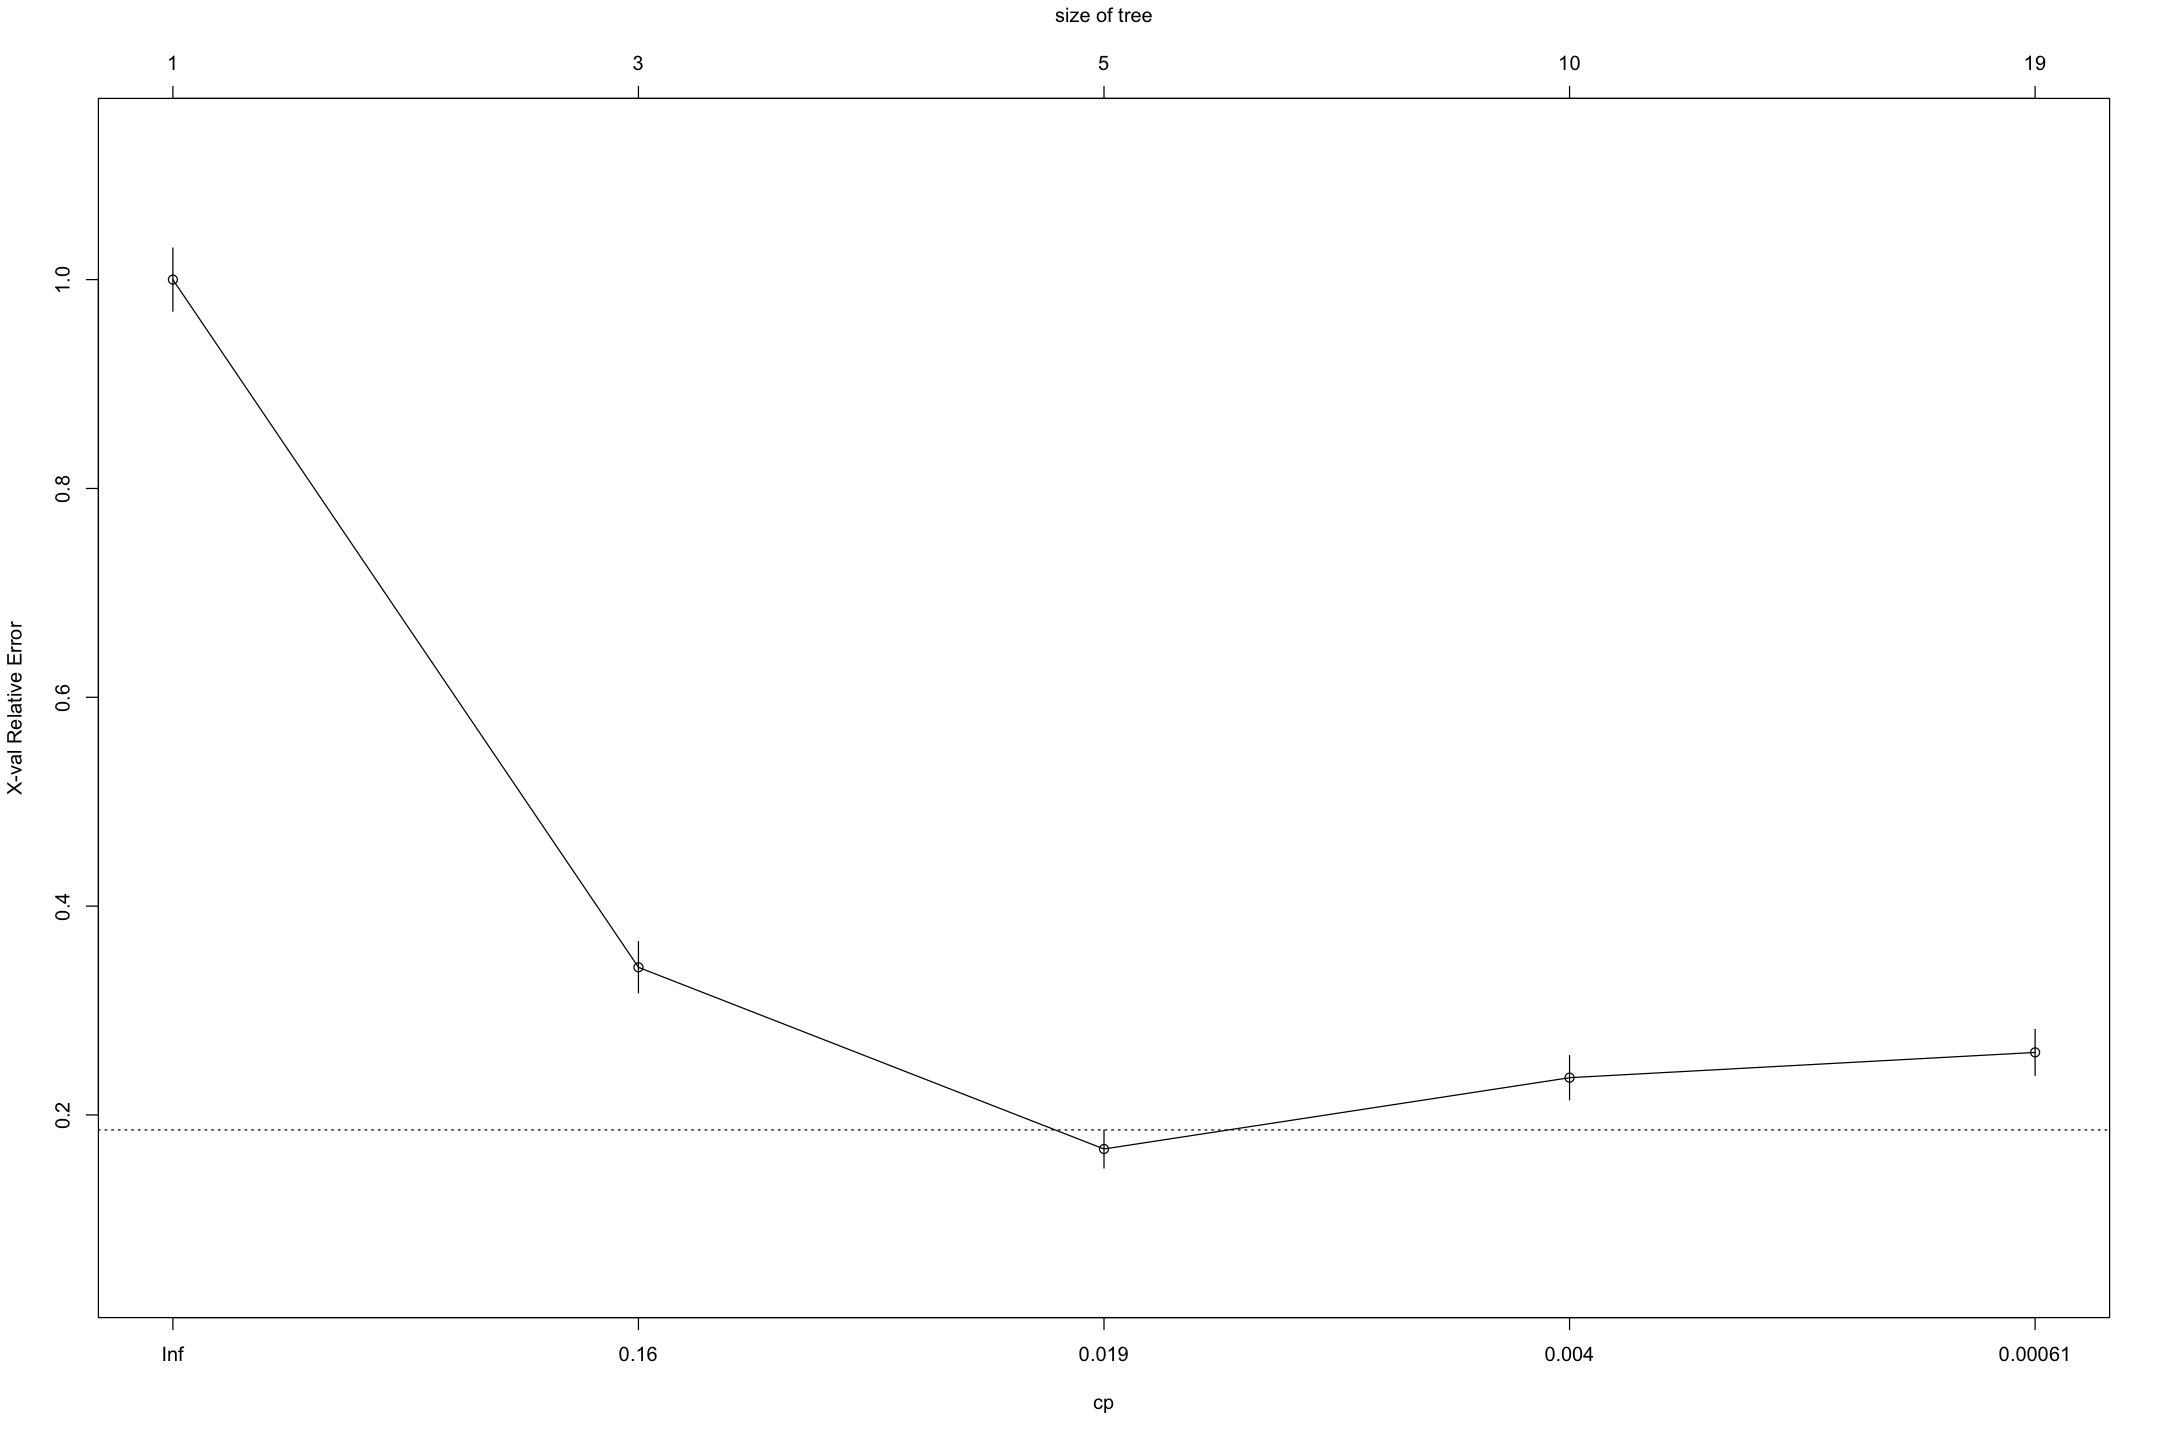

Nombre de noeuds dans l'arbre elague : 9 
Nombre de feuilles dans l'arbre elague : 19 


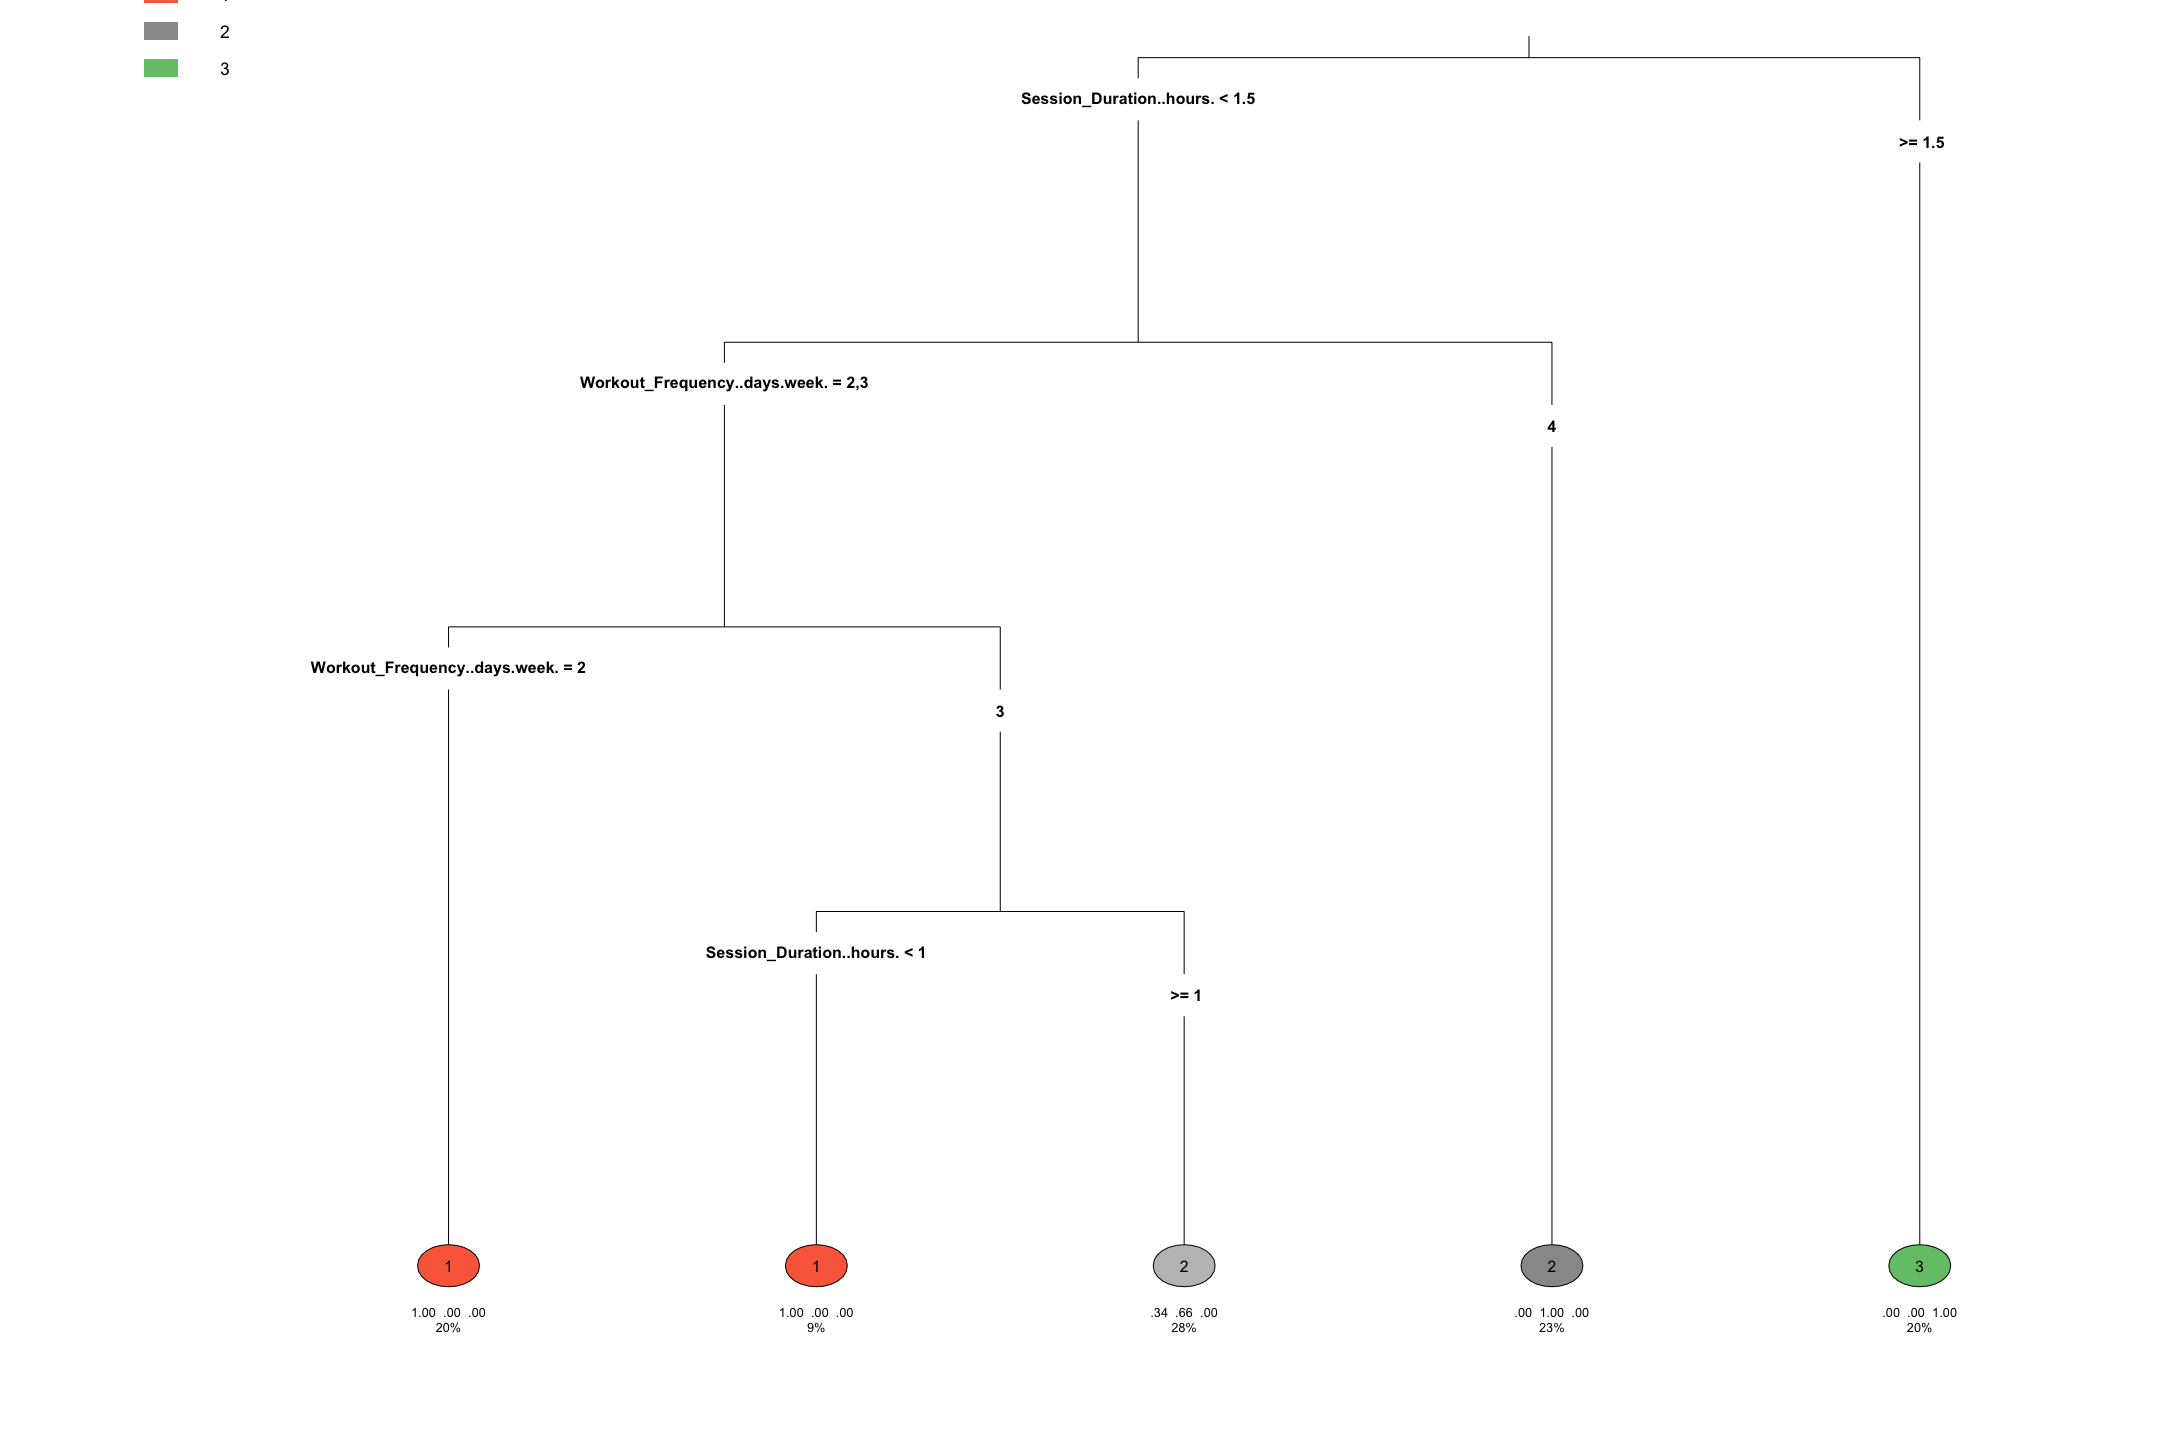

In [4]:
# Ajuster l'arbre avec un cp faible pour explorer toute la complexité
tree.class.exp <- rpart(Experience_Level ~ ., data = gym_train, method = "class", control = rpart.control(cp = 0.0001))

# Visualiser la courbe d'erreur de validation croisée
plotcp(tree.class.exp)

# Extraire la table des cp
cp_table <- tree.class.exp$cptable

# Trouver le cp optimal (celui qui minimise l'erreur de validation croisée)
min_xerror_idx <- which.min(cp_table[,"xerror"])
cp_optimal <- cp_table[min_xerror_idx, "CP"]
cat("Le cp optimal est :", cp_optimal, "\n")

# Élaguer l'arbre avec le cp optimal
tree.class.exp.pruned <- prune(tree.class.exp, cp = cp_optimal)

# Visualiser l'arbre élagué
rpart.plot(tree.class.exp.pruned, extra = 104, type = 3, under = TRUE, cex = 0.8, tweak = 1)

# Prédictions sur le jeu de test
pred_classes_test <- predict(tree.class.exp.pruned, gym_test, type = "class")

# Matrice de confusion
conf_matrix_test <- confusionMatrix(pred_classes_test, gym_test$Experience_Level)

# Afficher le nombre de noeuds et de feuilles
cat("Nombre de noeuds dans l'arbre elague :", length(tree.class.exp.pruned$frame$var), "\n")
cat("Nombre de feuilles dans l'arbre elague :", length(tree.class.exp$frame$var[tree.class.exp$frame$var == "<leaf>"]), "\n")

In [5]:
# Prédictions sur le jeu de test (classes et probabilités)
pred_classes_test <- predict(tree.class.exp.pruned, gym_test, type = "class")
pred_probs_test <- predict(tree.class.exp.pruned, gym_test, type = "prob")

# Prédictions sur le jeu d'entraînement (classes et probabilités)
pred_classes_train <- predict(tree.class.exp.pruned, gym_train, type = "class")
pred_probs_train <- predict(tree.class.exp.pruned, gym_train, type = "prob")

# Matrices de confusion
conf_matrix_test <- confusionMatrix(pred_classes_test, gym_test$Experience_Level)
conf_matrix_train <- confusionMatrix(pred_classes_train, gym_train$Experience_Level)

# Log loss (nécessite MLmetrics)
actual_matrix_test <- model.matrix(~gym_test$Experience_Level-1)
actual_matrix_train <- model.matrix(~gym_train$Experience_Level-1)
logloss_test <- MultiLogLoss(y_pred = pred_probs_test, y_true = actual_matrix_test)
logloss_train <- MultiLogLoss(y_pred = pred_probs_train, y_true = actual_matrix_train)

# Affichage des résultats
cat("Test Set Performance:\n")
cat("- Accuracy:", round(conf_matrix_test$overall["Accuracy"], 4), "\n")
cat("- Log loss:", round(logloss_test, 4), "(lower is better)\n")
cat("- Confusion Matrix:\n")
print(conf_matrix_test$table)
cat("\n")

cat("Training Set Performance:\n")
cat("- Accuracy:", round(conf_matrix_train$overall["Accuracy"], 4), "\n")
cat("- Log loss:", round(logloss_train, 4), "(lower is better)\n")
cat("- Confusion Matrix:\n")
print(conf_matrix_train$table)

Test Set Performance:
- Accuracy: 0.9021 
- Log loss: 0.1977 (lower is better)
- Confusion Matrix:
          Reference
Prediction  1  2  3
         1 56  0  0
         2 19 81  0
         3  0  0 38

Training Set Performance:
- Accuracy: 0.9037 
- Log loss: 0.1817 (lower is better)
- Confusion Matrix:
          Reference
Prediction   1   2   3
         1 226   0   0
         2  75 325   0
         3   0   0 153


#### Complexité de l’arbre avant et après élagage

- **Premier arbre (cp très faible, arbre complexe) :**
  - Nombre de nœuds dans l’arbre : **37**
  - Nombre de feuilles dans l’arbre : **19**

  Cet arbre très développé s’ajuste fortement aux données d’entraînement, ce qui favorise le sur-apprentissage.

- **Arbre élagué (cp optimal) :**
  - Nombre de nœuds dans l’arbre élagué : **9**
  - Nombre de feuilles dans l’arbre élagué : **19**

  Après élagage, l’arbre conserve le même nombre de feuilles (donc la même capacité de séparation des classes), mais avec beaucoup moins de nœuds internes. Cela signifie que la structure de l’arbre est simplifiée, ce qui améliore la robustesse et la capacité de généralisation du modèle.

#### Résultats avant et après élagage

**Avant élagage (cp très faible, arbre complexe)**

- **Jeu de test :**
  - Accuracy : 0.8711
  - Log loss : 0.2528
  - L’arbre distingue bien les classes, mais il y a des confusions entre les classes 1 et 2.

- **Jeu d’entraînement :**
  - Accuracy : 0.9474
  - Log loss : 0.1257
  - Très bonne performance, mais l’écart avec le test montre un sur-apprentissage.

---

**Après élagage (cp optimal = 0.0044, arbre plus simple)**

- **Jeu de test :**
  - Accuracy : 0.9021 (en hausse)
  - Log loss : 0.1977 (en baisse, donc meilleur)
  - La matrice de confusion montre moins d’erreurs, surtout pour la classe 2.

- **Jeu d’entraînement :**
  - Accuracy : 0.9037 (en baisse, mais plus proche du test)
  - Log loss : 0.1817 (en légère hausse, mais toujours bonne)
  - Les performances sont désormais très proches entre entraînement et test.

---

**Interprétation**

L’élagage avec le cp optimal a permis de réduire le sur-apprentissage : l’écart entre les performances d’entraînement et de test a diminué.  
Le modèle généralise mieux : la précision sur le test augmente, la log loss diminue.  
L’arbre est plus simple et plus robuste : il fait moins d’erreurs sur des données non vues, même si la précision d’entraînement baisse un peu (ce qui est normal et souhaité).

**Conclusion :**  
L’utilisation du cp optimal améliore la capacité de généralisation du modèle, en évitant qu’il ne s’ajuste trop aux particularités du jeu d’entraînement. C’est exactement l’objectif de la validation croisée et de l’élagage.

### Random Forests and Boosting
- Random forests with `mtry` and Brieman criterion
- Regularization with Boosting
- Using Bootsratp
- **plot** feature importance

#### Simple Random Forest

Entraînement du modèle Random Forest

L'objectif des forets aléatoires est de réduire la variance des arbres tout en conservant leur pouvoir prédictif via le bagging, qui est une technique combinant bootstraping et agrégation d'arbres.

In [6]:
library(randomForest)

Warning message:
"le package 'randomForest' a 'et'e compil'e avec la version R 4.4.1"
randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attachement du package : 'randomForest'


L'objet suivant est masqu'e depuis 'package:gridExtra':

    combine


L'objet suivant est masqu'e depuis 'package:dplyr':

    combine


L'objet suivant est masqu'e depuis 'package:ggplot2':

    margin




In [18]:
set.seed(24)
# Entraînement du modèle Random Forest
rf_model <- randomForest(Experience_Level ~ ., 
                         data = gym_train,
                         ntree = 500,           # nombre d’arbres
                         mtry = 4,              # nombre de variables testées à chaque split
                         importance = TRUE)     # permet de calculer l’importance des variables

# Résumé du modèle
print(rf_model)


Call:
 randomForest(formula = Experience_Level ~ ., data = gym_train,      ntree = 500, mtry = 4, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 10.53%
Confusion matrix:
    1   2   3 class.error
1 234  67   0  0.22259136
2  15 310   0  0.04615385
3   0   0 153  0.00000000


### Interprétation du modèle Random Forest

Le modèle Random Forest a été entraîné pour prédire la variable **Experience_Level** à partir des données d’entraînement.

- **Nombre d’arbres :** 500
- **Variables testées à chaque split (mtry) :** 4

#### Résultats sur le jeu d’entraînement (OOB)

- **Taux d’erreur OOB (Out-Of-Bag) :** 10,53 %
  - Cela signifie que le modèle se trompe en moyenne sur 10,53 % des observations non vues lors de la construction de chaque arbre.
- **Matrice de confusion :**
  - **Classe 1 :** 230 bien classés, 71 mal classés (erreur : 23,6 %)
  - **Classe 2 :** 314 bien classés, 11 mal classés (erreur : 3,4 %)
  - **Classe 3 :** 153 bien classés, 0 mal classés (erreur : 0 %)

#### Interprétation

- Le modèle distingue très bien la classe 3 (aucune erreur) et la classe 2 (faible taux d’erreur).
- Il a plus de difficultés à bien prédire la classe 1 (23,6 % d’erreur).
- Le taux d’erreur global est faible, ce qui indique une bonne capacité de classification sur les données d’entraînement.
- L’utilisation de 500 arbres et la sélection aléatoire de variables à chaque split permettent de limiter le sur-apprentissage et d’améliorer la robustesse du modèle.

Intéressons-nous maintenant à l'évaluation de notre modèle sur nos jeux d'entraînement et de test.


In [20]:
# Prédictions Random Forest sur le jeu de test (classes et probabilités)
pred_classes_test_rf <- predict(rf_model, gym_test, type = "class")
pred_probs_test_rf <- predict(rf_model, gym_test, type = "prob")

# Prédictions sur le jeu d'entraînement
pred_classes_train_rf <- predict(rf_model, gym_train, type = "class")
pred_probs_train_rf <- predict(rf_model, gym_train, type = "prob")

# Matrices de confusion
conf_matrix_test_rf <- confusionMatrix(pred_classes_test_rf, gym_test$Experience_Level)
conf_matrix_train_rf <- confusionMatrix(pred_classes_train_rf, gym_train$Experience_Level)

# Log loss (nécessite MLmetrics)
actual_matrix_test_rf <- model.matrix(~gym_test$Experience_Level-1)
actual_matrix_train_rf <- model.matrix(~gym_train$Experience_Level-1)
logloss_test_rf <- MultiLogLoss(y_pred = pred_probs_test_rf, y_true = actual_matrix_test_rf)
logloss_train_rf <- MultiLogLoss(y_pred = pred_probs_train_rf, y_true = actual_matrix_train_rf)

# Affichage des résultats
cat("Test Set Performance (Random Forest):\n")
cat("- Accuracy:", round(conf_matrix_test_rf$overall["Accuracy"], 4), "\n")
cat("- Log loss:", round(logloss_test_rf, 4), "(lower is better)\n")
cat("- Confusion Matrix:\n")
print(conf_matrix_test_rf$table)
cat("\n")

cat("Training Set Performance (Random Forest):\n")
cat("- Accuracy:", round(conf_matrix_train_rf$overall["Accuracy"], 4), "\n")
cat("- Log loss:", round(logloss_train_rf, 4), "(lower is better)\n")
cat("- Confusion Matrix:\n")
print(conf_matrix_train_rf$table)

Test Set Performance (Random Forest):
- Accuracy: 0.8866 
- Log loss: 0.2397 (lower is better)
- Confusion Matrix:
          Reference
Prediction  1  2  3
         1 58  5  0
         2 17 76  0
         3  0  0 38

Training Set Performance (Random Forest):
- Accuracy: 1 
- Log loss: 0.0647 (lower is better)
- Confusion Matrix:
          Reference
Prediction   1   2   3
         1 301   0   0
         2   0 325   0
         3   0   0 153


### Interprétation des performances sur le jeu d'entraînement

Le modèle Random Forest affiche une précision (accuracy) de **100%** sur le jeu d'entraînement, ce qui signifie qu’il a correctement classé **l’intégralité des observations** de cet échantillon. Bien que ce résultat puisse sembler excellent, il doit être interprété avec prudence. En effet, cette absence totale d’erreurs sur les données d'entraînement est généralement le signe d’un **surapprentissage** (*overfitting*), c’est-à-dire que le modèle a appris **par cœur les données** plutôt que de généraliser les tendances sous-jacentes.

Ce phénomène est confirmé par la comparaison avec l’estimation de l’erreur **OOB (Out-Of-Bag)**, fournie par le modèle pendant l'entraînement, qui était d’environ **10,78%**. Cette erreur OOB est considérée comme une estimation plus fiable de la performance réelle, car elle est calculée à partir d'observations non utilisées pour construire chaque arbre.

Ainsi, bien que l’accuracy de 100% témoigne d’une forte capacité du modèle à mémoriser les données, elle ne garantit pas une bonne capacité de généralisation. L’évaluation sur un jeu de test indépendant reste indispensable pour valider les performances du modèle.


L'objectif des forêts aléatoires est de réduire la **variance des arbres de décision** tout en conservant leur pouvoir prédictif. Elles reposent sur la technique du **bagging**, qui combine **bootstraping** (tirages aléatoires avec remise) et **agrégation de prédictions** (par vote majoritaire dans le cas de la classification).

Contrairement à un arbre classique, à chaque nœud d’un arbre de la forêt, **un sous-ensemble aléatoire de variables est sélectionné** (de taille `mtry`), et la **meilleure variable parmi ce sous-ensemble** est utilisée pour réaliser la division. Ce mécanisme permet de **décorréler les arbres entre eux**, ce qui renforce la robustesse globale du modèle.

### Paramètres à optimiser :

- **`mtry`** : nombre de variables sélectionnées aléatoirement à chaque split.
    - Dans le cas de la **classification**, la valeur empirique par défaut est `mtry ≈ √p`, où `p` est le nombre total de variables explicatives. Ici, `p = 14`, donc `mtry` vaut par défaut `√p = √14 = 4`.
    - L’optimisation de `mtry` est réalisée via la fonction `tuneRF`, qui cherche le meilleur compromis entre complexité et performance. Cette fonction commence à une valeur initiale (`mtry = 4` ici) et teste des valeurs supérieures et inférieures tant que l’erreur de généralisation mesurée par le taux d’erreur **OOB (Out-Of-Bag)** s’améliore d’au moins 5% (ce seuil est modifiable).

- **`ntree`** : nombre d’arbres dans la forêt.
    - En général, `ntree` varie de 100 à 500. Au-delà, les gains de performance sont marginaux, mais cela peut améliorer la **stabilité** de la prédiction. Dans ce projet, nous utilisons `ntree = 500` pour garantir la convergence des résultats.

Cette combinaison d’aléatoire (dans les données et dans les variables) permet à Random Forest d’offrir un excellent compromis entre **performance** et **généralisation**, même sans réglage excessif d’hyperparamètres.


##### Optimisation du `mtry`

mtry = 3  OOB error = 10.78% 
Searching left ...
mtry = 2 	OOB error = 11.68% 
-0.08333333 0.05 
Searching right ...
mtry = 4 	OOB error = 10.27% 
0.04761905 0.05 
Optimal mtry value: 4 


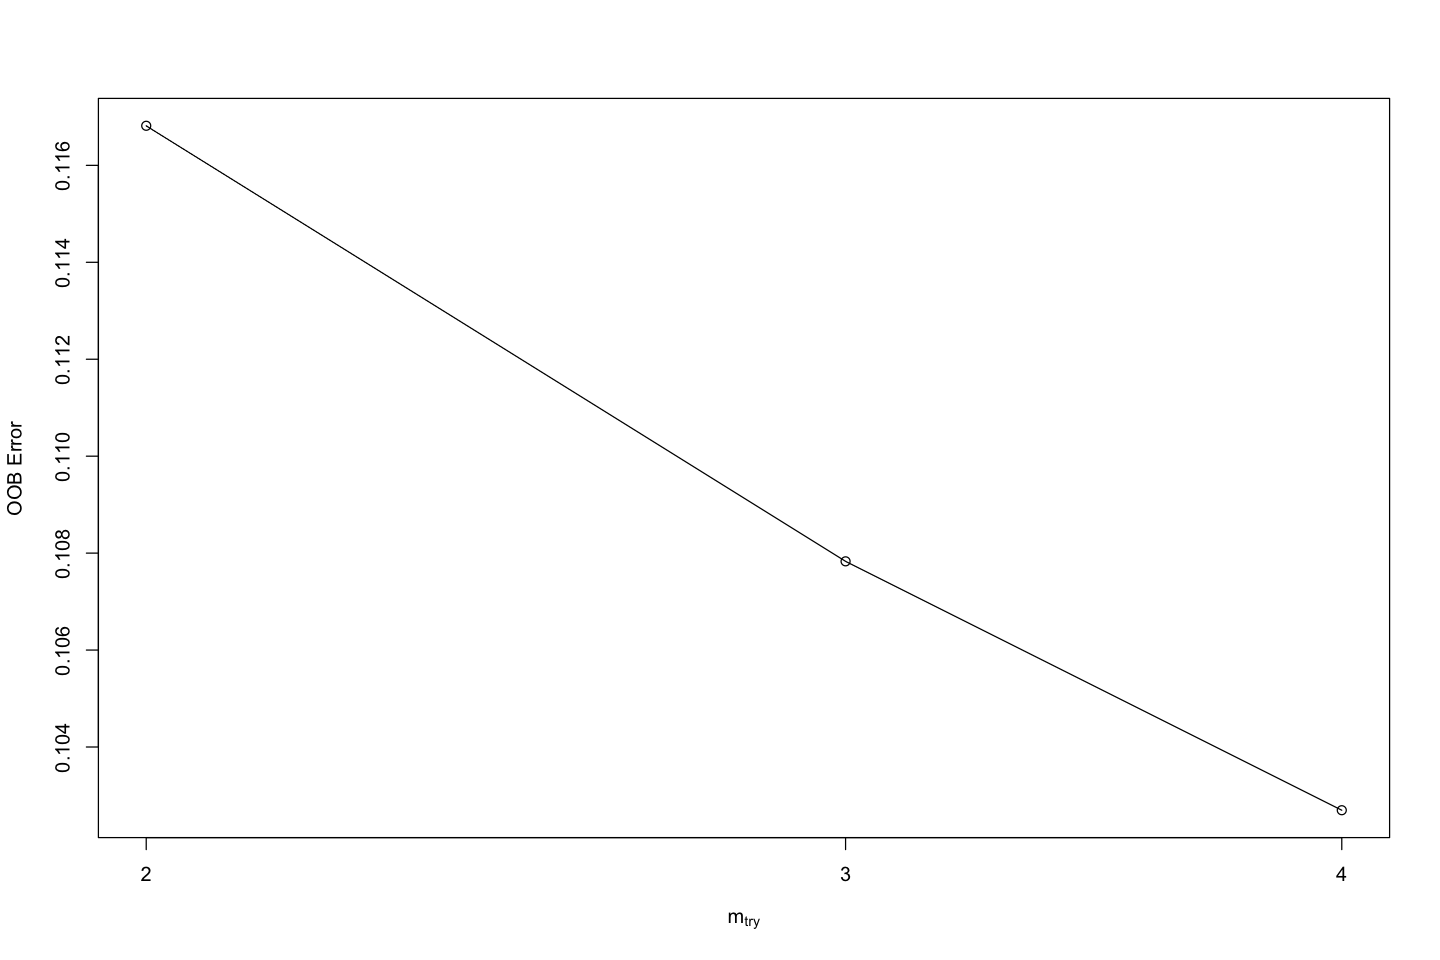

In [34]:
set.seed(24)

# Optimisation du mtry avec tuneRF
best_mtry <- tuneRF(x = gym_train[ , -which(names(gym_train) == "Experience_Level")],
                    y = gym_train$Experience_Level,
                    stepFactor = 1.5,
                    improve = 0.05,
                    ntreeTry = 100,
                    trace = TRUE,
                    plot = TRUE,
                    doBest = TRUE)

optimal_mtry <- best_mtry$mtry
cat("Optimal mtry value:", optimal_mtry, "\n")

Le paramètre `mtry` a été optimisé automatiquement à l'aide de la fonction `tuneRF()`, qui teste différentes valeurs de `mtry` autour d'une valeur initiale (ici, `√p = 4`), en les multipliant ou divisant par un facteur `stepFactor = 1.5`. L'évaluation de chaque `mtry` est réalisée à l'aide de 100 arbres (`ntreeTry = 100`) afin d'obtenir une estimation rapide mais fiable de l'erreur OOB. 

Le processus de tuning s'arrête dès qu'aucune amélioration significative (au moins `5%`) de l'erreur OOB n’est observée (`improve = 0.05`). L’option `doBest = TRUE` permet enfin de réentraîner automatiquement un modèle avec la meilleure valeur trouvée, ce qui facilite l'intégration du tuning dans le workflow.

Cette procédure a confirmé que `mtry = 4` (valeur théorique par défaut pour la classification avec 14 variables explicatives) offrait les meilleures performances, sans amélioration notable au-delà.


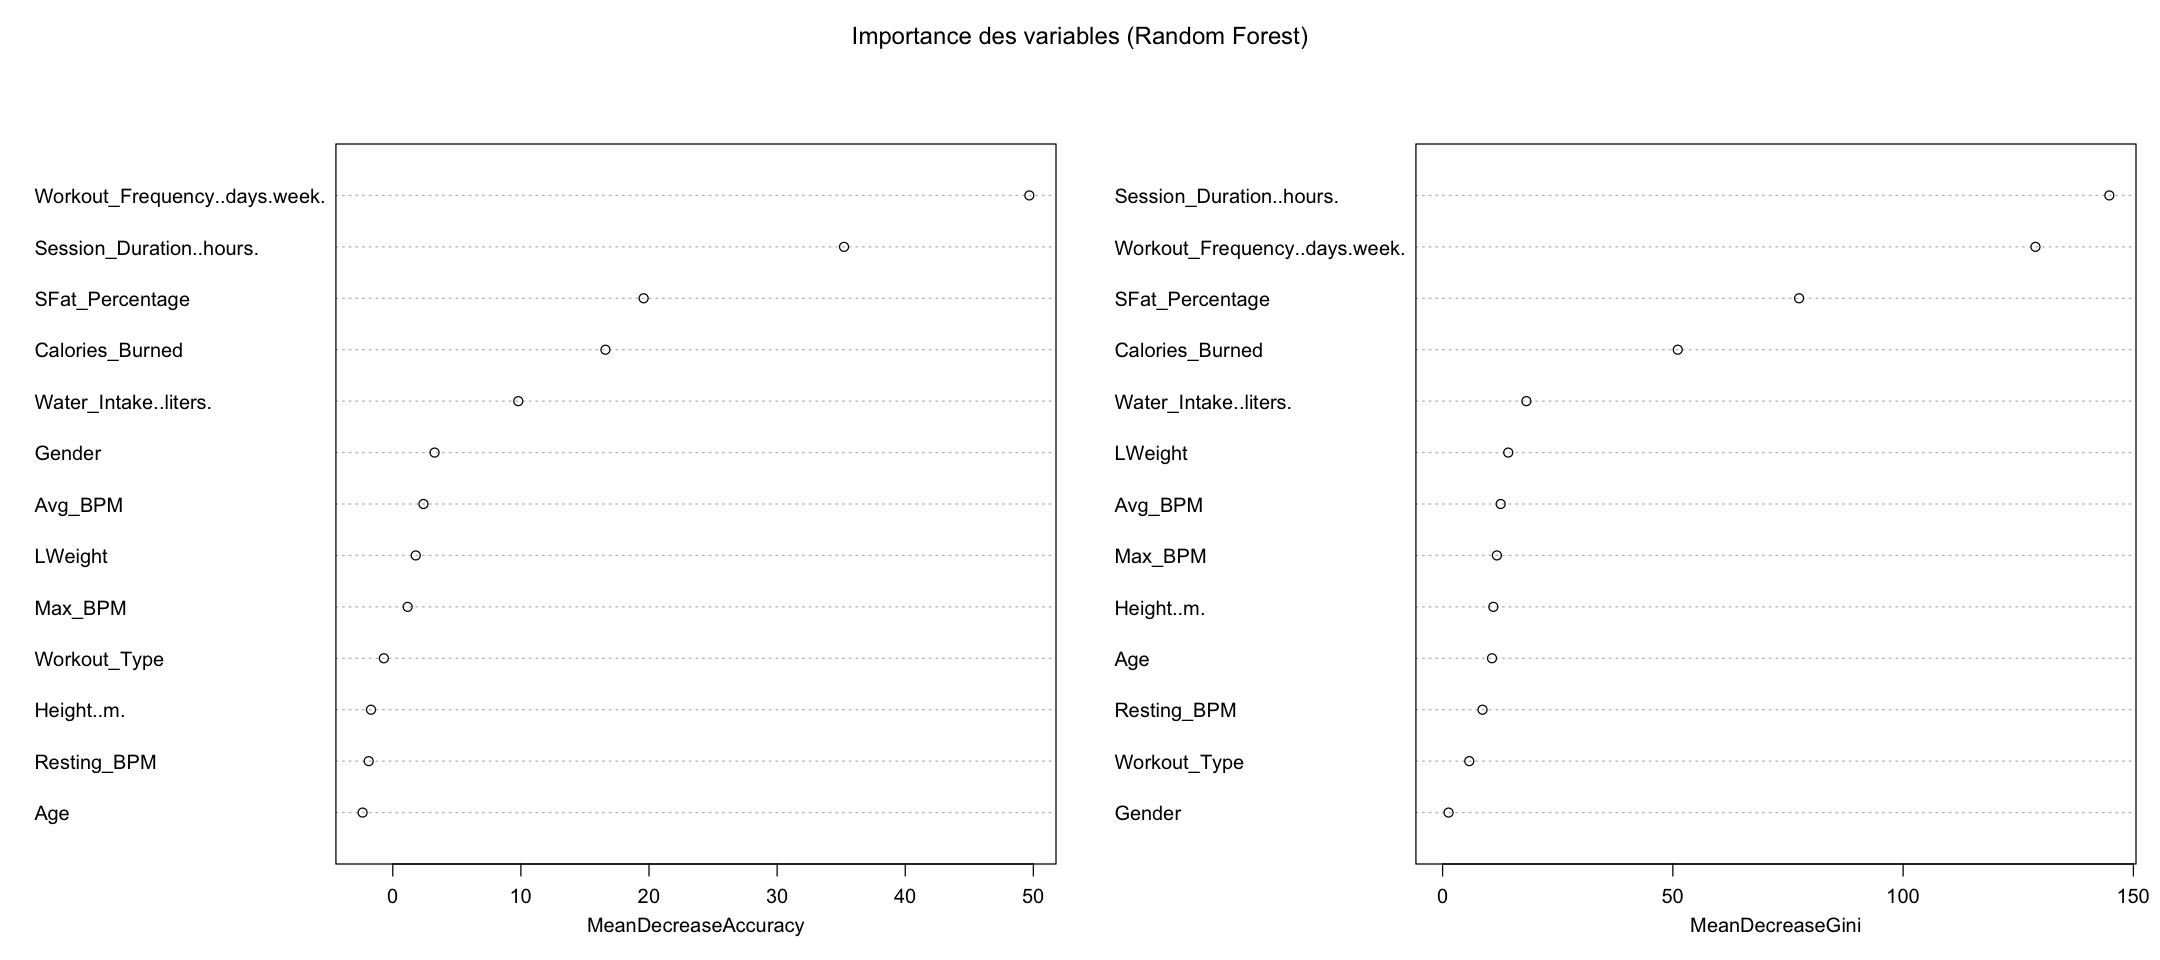

In [41]:
# Importance des variables
library(ggRandomForests)

#Plot importance
varImpPlot(rf_model, main = "Importance des variables (Random Forest)")

L'importance des variables a été évaluée à l’aide des mesures intégrées à l’algorithme Random Forest. Deux métriques complémentaires ont été analysées :

- **Mean Decrease in Accuracy** : elle mesure la perte de précision du modèle lorsque les valeurs d’une variable sont aléatoirement permutées. Cette mesure est considérée comme la plus fiable car elle reflète directement l’impact de la variable sur la performance globale du modèle.
- **Mean Decrease in Gini** : elle correspond à la réduction moyenne de l’impureté des nœuds (indice de Gini) induite par l’utilisation d’une variable pour diviser les données dans les arbres. Bien qu’efficace, cette métrique peut être biaisée en faveur des variables numériques continues.

Le graphique montre que des variables telles que `Session_Duration..hours.`, `Workout_Frequency` ou encore `Fat_Percentage` sont parmi les plus influentes dans la prédiction du niveau d’expérience. Ces résultats sont cohérents avec l’analyse exploratoire, qui avait déjà mis en évidence des corrélations fortes entre ces variables et la variable cible `Experience_Level`.

Cette observation est tout à fait cohérente : les profils les plus expérimentés sont aussi ceux qui cumulent une fréquence d'entraînement élevée, un volume d’exercice important et un taux de masse grasse plus bas, autant d’indicateurs caractéristiques d’une pratique sportive régulière et avancée.

L’analyse de l’importance des variables permet non seulement d’interpréter le modèle, mais aussi d’identifier les facteurs les plus déterminants dans la progression des adhérents d'une salle de sport.


#### Boosting
##### Avec la librairie `gbm`

In [ ]:
attributes(boost.reg.cal)

$names
 [1] "initF"             "fit"               "train.error"      
 [4] "valid.error"       "oobag.improve"     "trees"            
 [7] "c.splits"          "bag.fraction"      "distribution"     
[10] "interaction.depth" "n.minobsinnode"    "num.classes"      
[13] "n.trees"           "nTrain"            "train.fraction"   
[16] "response.name"     "shrinkage"         "var.levels"       
[19] "var.monotone"      "var.names"         "var.type"         
[22] "verbose"           "data"              "Terms"            
[25] "cv.error"          "cv.folds"          "call"             
[28] "m"                 "cv.fitted"        

$class
[1] "gbm"

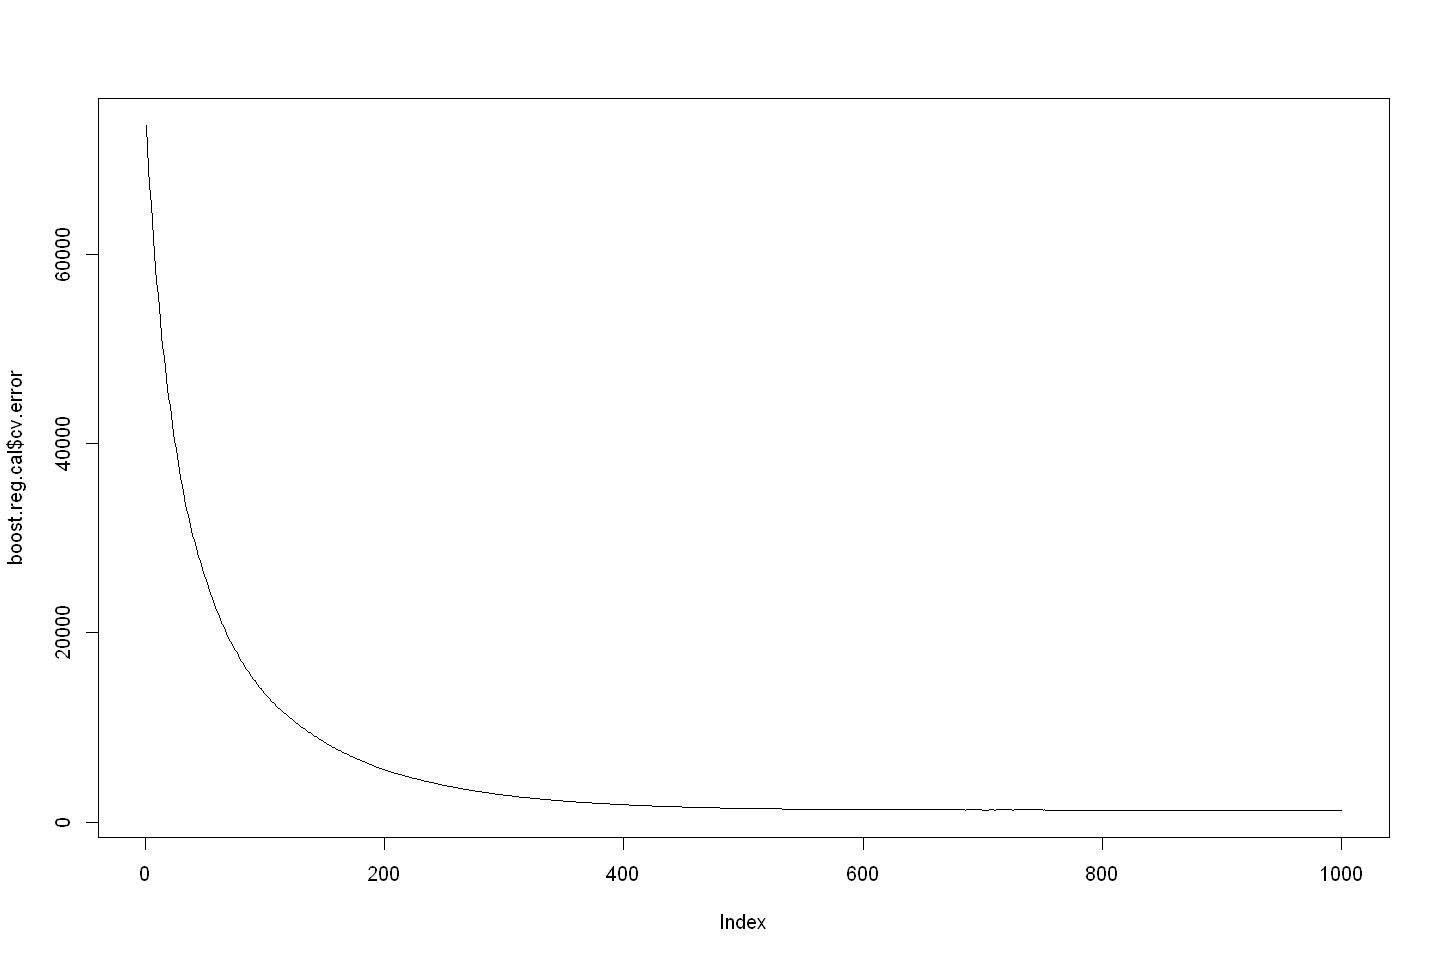

In [ ]:
library(gbm)
options(repr.plot.width=12, repr.plot.height=8)
boost.reg.cal = gbm(Calories_Burned ~ ., data = gym_train, distribution = "gaussian", n.trees = 1000, 
    cv.folds = 10, n.minobsinnode = 5, shrinkage = 0.03, verbose = FALSE)
# fixer verbose à FALSE pour éviter trop de sorties
plot(boost.reg.cal$cv.error, type = "l")

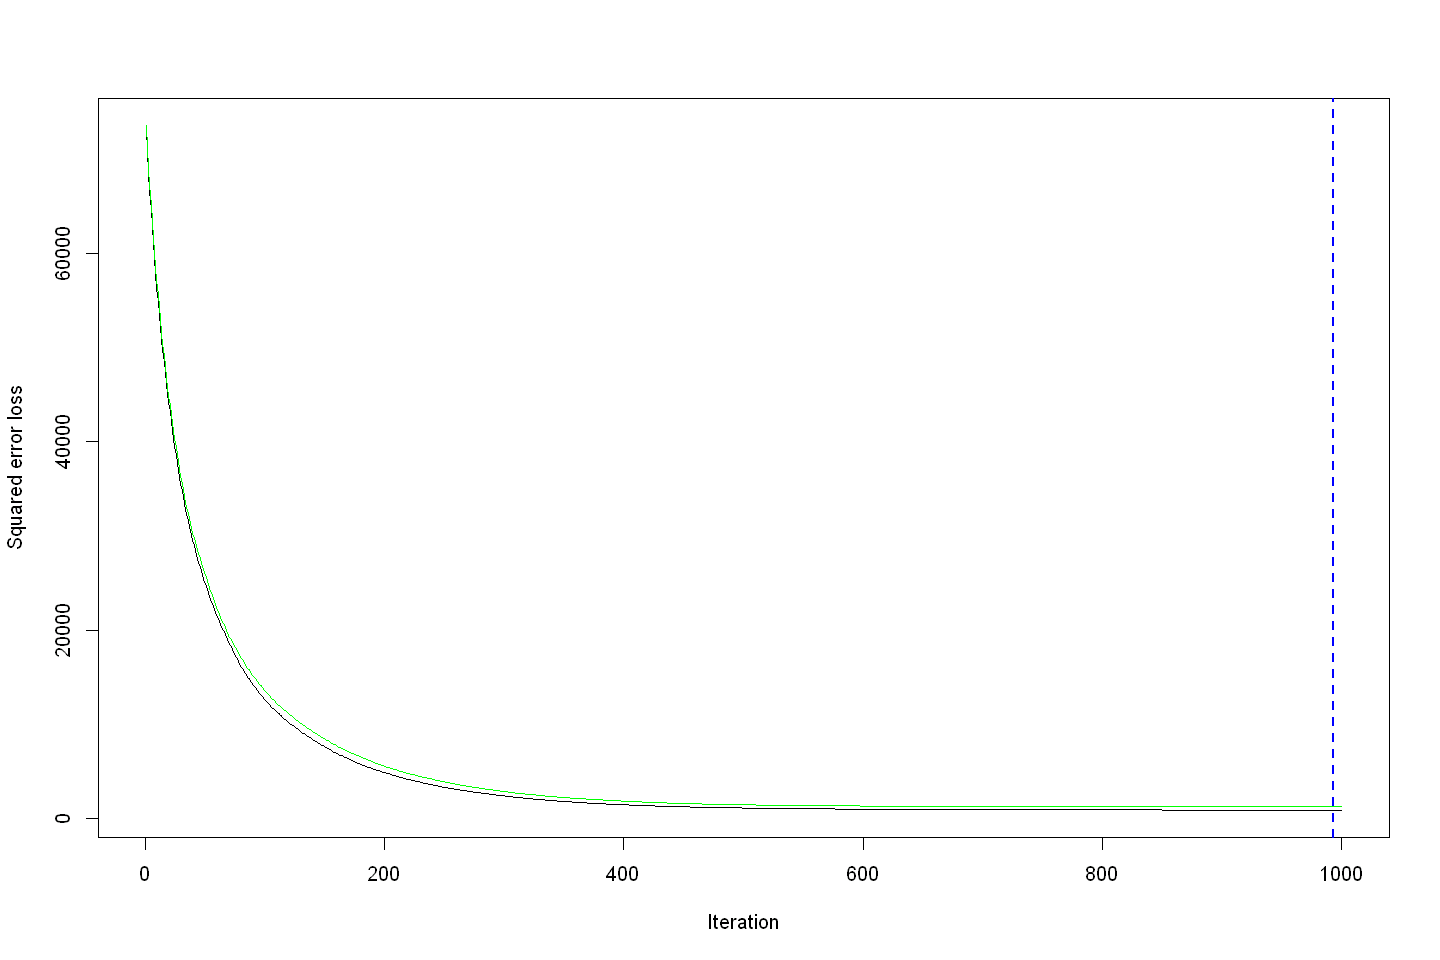

In [ ]:
best.iter <- gbm.perf(boost.reg.cal, method="cv")

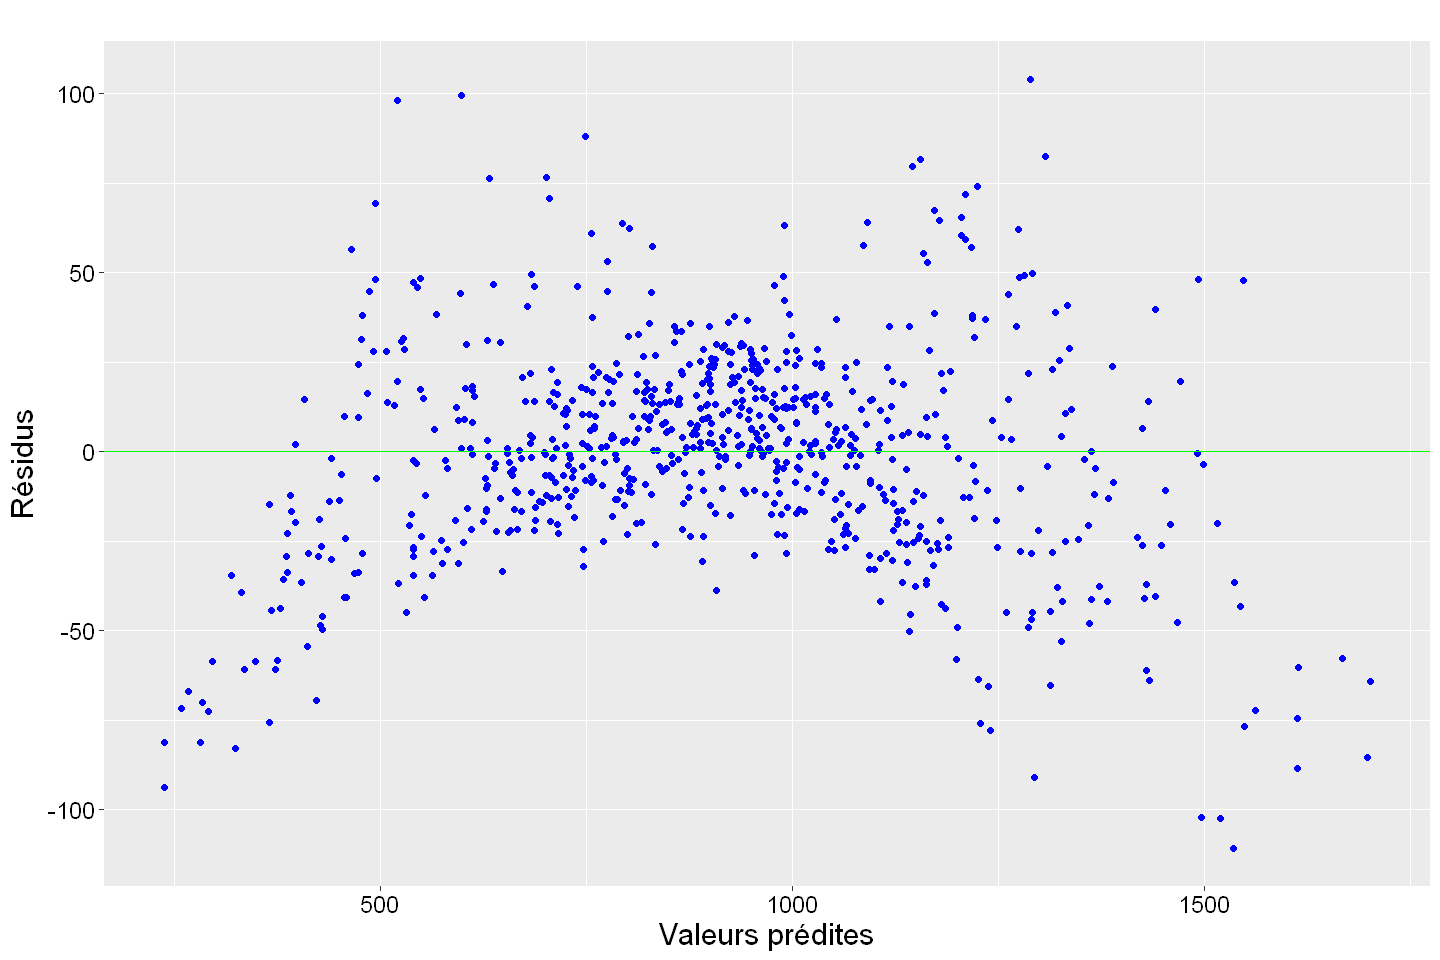

In [ ]:
fit.boostr.cal <- boost.reg.cal$fit
res.boostr.cal <- fit.boostr.cal - gym_train[,"Calories_Burned"]
gplot.res(fit.boostr.cal, res.boostr.cal, titre="")

In [ ]:
# plot(gg_vimp(importance(boost.reg.cal)))

##### Avec XGBoost
- Optimize number of trees and learning rate.
- Use early stopping to prevent overfitting.
- Plot: SHAP values for interpretability.

In [ ]:
library(xgboost)

xgb.mat.cal = xgb.DMatrix(
    data = model.matrix(Calories_Burned ~ . -1, data = gym_train),
    label = gym_train$Calories_Burned
)

params <- list(
  booster = "gbtree",
  objective = "reg:squarederror",
  eval_metric = "rmse",
  eta = 0.1,
  max_depth = 4,
  gamma = 0,
  subsample = 0.8,
  colsample_bytree = 0.8,
  lambda = 0, # L2 Reg
  alpha = 1 # L1 Reg
)
xgb.reg.cal <- xgb.cv(params = params, data = xgb.mat, 
    nround = 1000, verbose = FALSE, nfold = 10, nthread=6)

# xgb.reg.cal <- xgboost(data = xgb.mat,
#     nrounds = 1000, eta = 0.1, max_depth = 3, gamma = 0, 
#     min_child_weight = 1, subsample = 0.8, colsample_bytree = 0.8, 
#     lambda = 1, alpha = 0, scale_pos_weight = 1, 
#     objective = "reg:squarederror", eval_metric = "rmse", 
#     verbose = FALSE)

In [ ]:
attributes(xgb.reg.cal)

$names
[1] "call"           "params"         "callbacks"      "evaluation_log"
[5] "niter"          "nfeatures"      "folds"         

$class
[1] "xgb.cv.synchronous"

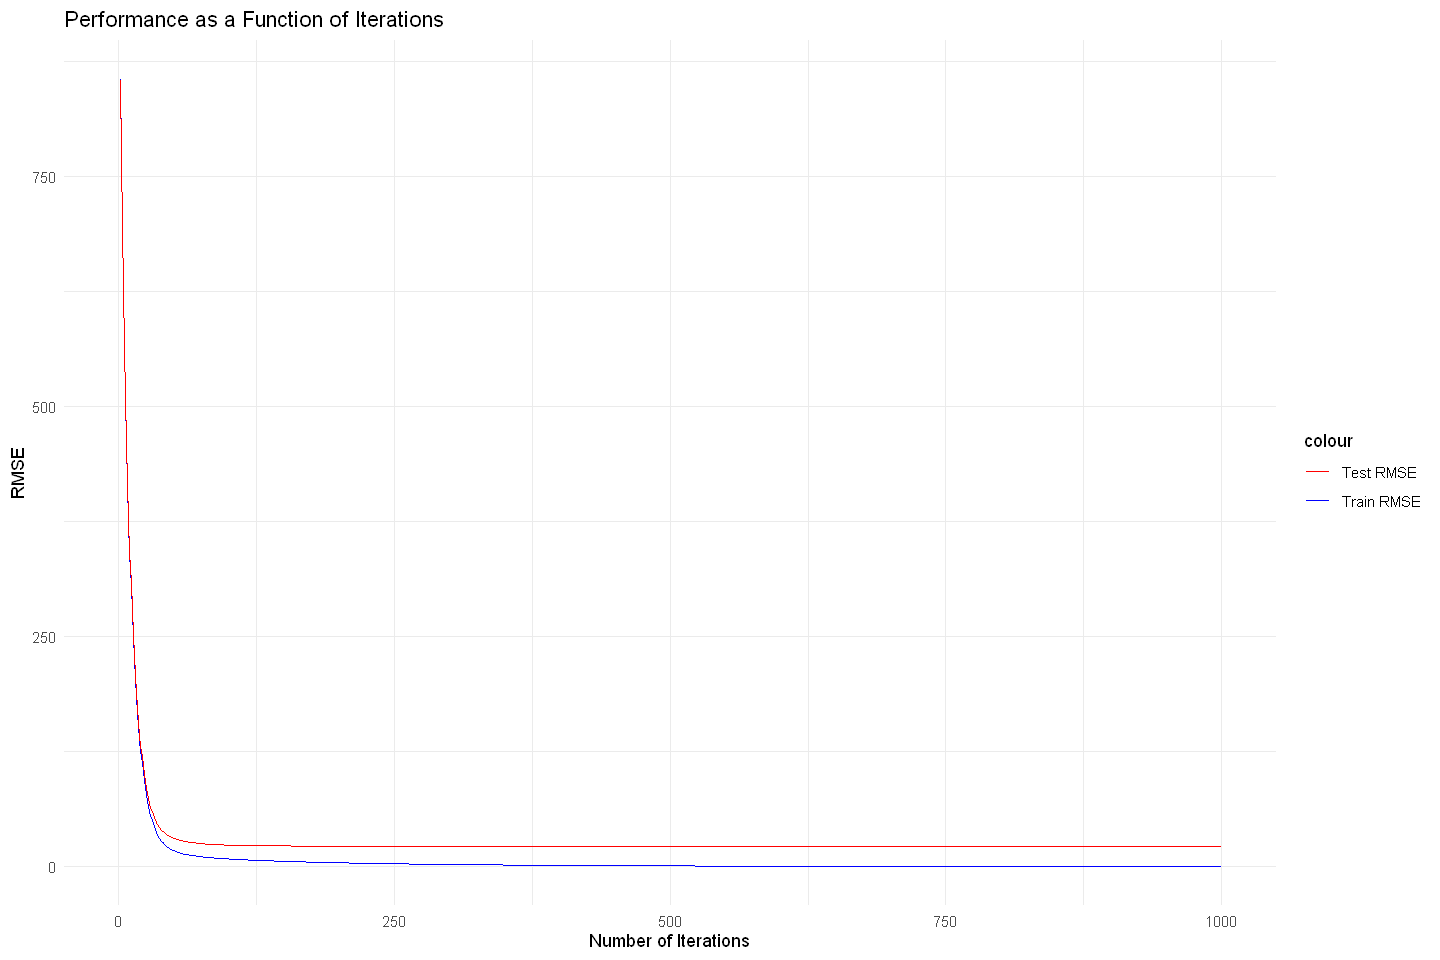

In [ ]:
# Extract evaluation log
eval_log <- xgb.reg.cal$evaluation_log

# Plot RMSE as a function of the number of iterations
options(repr.plot.width=12, repr.plot.height=8)
ggplot(eval_log, aes(x = iter)) +
    geom_line(aes(y = train_rmse_mean, color = "Train RMSE")) +
    geom_line(aes(y = test_rmse_mean, color = "Test RMSE")) +
    labs(
        title = "Performance as a Function of Iterations",
        x = "Number of Iterations",
        y = "RMSE"
    ) +
    scale_color_manual(values = c("Train RMSE" = "blue", "Test RMSE" = "red")) +
    theme_minimal()

In [ ]:
library(caret)

# Define the parameter grid
tune_grid <- expand.grid(
  nrounds = 100,
  max_depth = c(3, 6, 10),
  eta = c(0.01, 0.1, 0.3),
  gamma = 0,
  colsample_bytree = c(0.7, 0.8, 0.9),
  min_child_weight = 1,
  subsample = c(0.7, 0.8, 0.9)
)

# Train control for cross-validation
train_control <- trainControl(
  method = "cv",
  number = 5,
  verboseIter = FALSE,
  allowParallel = TRUE
)

# Train the model using caret
xgb_model <- train(
  Calories_Burned ~ .,
  data = gym_train_scaled,
  method = "xgbTree",
  trControl = train_control,
  tuneGrid = tune_grid,
  metric = "RMSE"
)

   nrounds max_depth eta gamma colsample_bytree min_child_weight subsample
34     100         3 0.1     0              0.9                1       0.7
[1] "RMSE"


In [ ]:
# Best parameters
print(xgb_model$bestTune)
print(xgb_model$finalModel)

   nrounds max_depth eta gamma colsample_bytree min_child_weight subsample
34     100         3 0.1     0              0.9                1       0.7
##### xgb.Booster
raw: 117 Kb 
call:
  xgboost::xgb.train(params = list(eta = param$eta, max_depth = param$max_depth, 
    gamma = param$gamma, colsample_bytree = param$colsample_bytree, 
    min_child_weight = param$min_child_weight, subsample = param$subsample), 
    data = x, nrounds = param$nrounds, objective = "reg:squarederror")
params (as set within xgb.train):
  eta = "0.1", max_depth = "3", gamma = "0", colsample_bytree = "0.9", min_child_weight = "1", subsample = "0.7", objective = "reg:squarederror", validate_parameters = "TRUE"
xgb.attributes:
  niter
callbacks:
  cb.print.evaluation(period = print_every_n)
# of features: 18 
niter: 100
nfeatures : 18 
xNames : Age GenderMale LWeight Height..m. Max_BPM Avg_BPM Resting_BPM Session_Duration..hours. Workout_TypeHIIT Workout_TypeStrength Workout_TypeYoga SFat_Percentage Water_Inta

In [ ]:
res.xgb.cal <- predict(xgb_model$finalModel, newdata = xgb.mat.cal)
1 - mean(res.xgb.cal^2) / tss_cal

ERROR: Error in predict.xgb.Booster(xgb_model$finalModel, newdata = xgb.mat.cal): Feature names stored in `object` and `newdata` are different!


In [ ]:
attributes(xgb_model$finalModel)

$names
 [1] "handle"        "raw"           "niter"         "call"         
 [5] "params"        "callbacks"     "feature_names" "nfeatures"    
 [9] "xNames"        "problemType"   "tuneValue"     "obsLevels"    
[13] "param"        

$class
[1] "xgb.Booster"

In [ ]:
xgb.ggplot.deepness(xgb.reg.cal)

ERROR: Error in xgb.plot.deepness(model = model, plot = FALSE): model: Has to be either an xgb.Booster model generaged by the xgb.train function
or a data.table result of the xgb.importance function


In [ ]:
xgb.ggplot.importance(
    xgb.importance(model = xgb.reg.cal)
)

ERROR: Error in xgb.importance(model = xgb.reg.cal): model: must be an object of class xgb.Booster
